In [11]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from scipy.spatial import distance
from numpy.linalg import norm
import scipy.stats as stats
from scipy import optimize
from sklearn.neighbors import KernelDensity
import torch
import esm
from esm import pretrained

In [12]:
def CalculateAUC(true, predicted):
    data = np.vstack((predicted, true))
    res = stats.bootstrap((np.arange(0, data.shape[1]), ),
                       lambda idxs: metrics.roc_auc_score(data[1, idxs], data[0, idxs]),
                       method = 'percentile', confidence_level=0.95, random_state=0)

    auc = metrics.roc_auc_score(data[1, :], data[0, :])
    if auc > 0.5:
        return (auc, [res.confidence_interval.low, res.confidence_interval.high])
    else:
        return (1-auc, [1-res.confidence_interval.high, 1-res.confidence_interval.low])

In [13]:
def PlotAUC(true, predicted, name = None, color = None):
    fpr, tpr, threshold = metrics.roc_curve(y_true = true, y_score = predicted)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = name)
    plt.legend(loc="upper left")

In [23]:
#load fasta sequences into dictionary
file_name = '/school/workshop-data/crossreactivity_data/demonstration_data/Influenza_A_H3N2/influenza_a_h3n2_seq_head_target.fas'
with open(file_name, 'r') as input_file:
    seq_dict = {sequence.id : str(sequence.seq) for sequence in SeqIO.parse(input_file, "fasta")}

FileNotFoundError: [Errno 2] No such file or directory: '/school/workshop-data/crossreactivity_data/demonstration_data/Influenza_A_H3N2/influenza_a_h3n2_seq_head_target.fas'

In [15]:
#load dataset
data_csv = pd.read_csv('/home/elisenenkova/virus_cross_reactivity/Influenza_A/influenza_a_h3n2_cross_reactivity.csv')

In [18]:
# function to extract embeddings
def extract_representations(model, alphabet, number_of_chunks, layer_to_extract):
    batch_converter = alphabet.get_batch_converter()
    model.eval()

    data = list(seq_dict.items())
    n = 30
    data_chunks = [data[i:i + n] for i in range(0, len(data), n)]
    sequence_representations = []
    for chunk in data_chunks:
        batch_labels, batch_strs, batch_tokens = batch_converter(chunk)
        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    

        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[layer_to_extract])
        token_representations = results["representations"][layer_to_extract].numpy()
    
        for i, tokens_len in enumerate(batch_lens):
            sequence_representations.append(token_representations[i, 1 : tokens_len - 1])
    return(sequence_representations)

In [21]:
model, alphabet = esm.pretrained.esm2_t30_150M_UR50D()

In [22]:
#extract representations
sequence_representations = extract_representations(model = model, alphabet = alphabet, number_of_chunks = 30, layer_to_extract = 30)

KeyboardInterrupt: 

In [11]:
emb_dict = dict(zip(seq_dict.keys(), sequence_representations))

In [12]:
def cosnorm (a, b):
    a = a.flatten()
    b = b.flatten()
    
    return np.dot(a, b)/(norm(a)*norm(b))

In [13]:
#calculate various distances
distances_emb_eucl = [] #Frobenius norm 
distances_emb_cos = [] #cosine norm
mean_distances_eucl = [] #sequnces represented as averaged token embeddings, euclidean norm
mean_distances_cos = [] #sequnces represented as averaged token embeddings, cosine norm
for row in list(data_csv.index):
    Strain1_name = data_csv.loc[row, 'Strain1']
    Strain2_name = data_csv.loc[row, 'Strain2']
    emb1 = emb_dict[strain1_name]
    emb2 = emb_dict[Strain2_name]
    distances_emb_eucl.append(norm(emb1 - emb2))
    distances_emb_cos.append(cosnorm(emb1, emb2))
    mean_distances_eucl.append(norm(np.mean(emb1, axis = 0) - np.mean(emb2, axis = 0)))
    mean_distances_cos.append(cosnorm(np.mean(emb1, axis = 0), np.mean(emb2, axis = 0)))

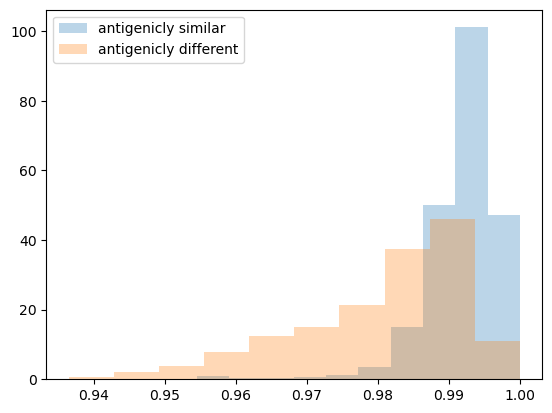

In [14]:
distances_emb_cos = np.array(distances_emb_cos)
plt.hist(distances_emb_cos[data_csv['Binary_crossreactivity'] == 1], density = True, alpha = 0.3, label = 'antigenicly similar')
plt.hist(distances_emb_cos[data_csv['Binary_crossreactivity'] == 0], density = True, alpha = 0.3, label = 'antigenicly different')
plt.legend()

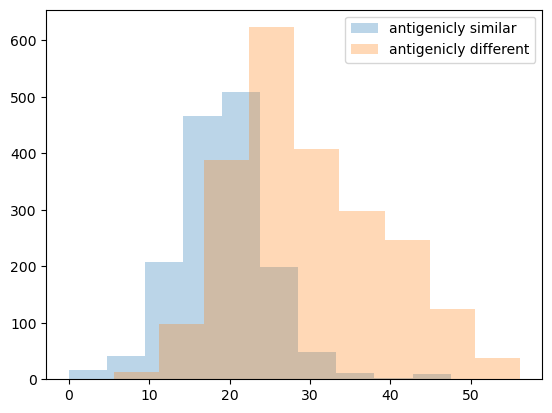

In [15]:
distances_emb_eucl = np.array(distances_emb_eucl)
plt.hist(distances_emb_eucl[data_csv['Binary_crossreactivity'] == 1], alpha = 0.3, label = 'antigenicly similar')
plt.hist(distances_emb_eucl[data_csv['Binary_crossreactivity'] == 0], alpha = 0.3, label = 'antigenicly different')
plt.legend()

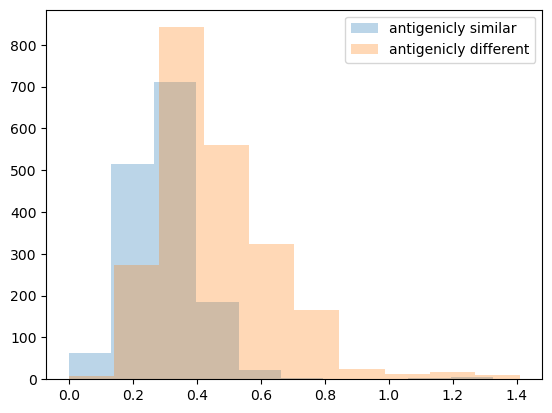

In [16]:
mean_distances_eucl = np.array(mean_distances_eucl)
plt.hist(mean_distances_eucl[data_csv['Binary_crossreactivity'] == 1], alpha = 0.3, label = 'antigenicly similar')
plt.hist(mean_distances_eucl[data_csv['Binary_crossreactivity'] == 0], alpha = 0.3, label = 'antigenicly different')
plt.legend()

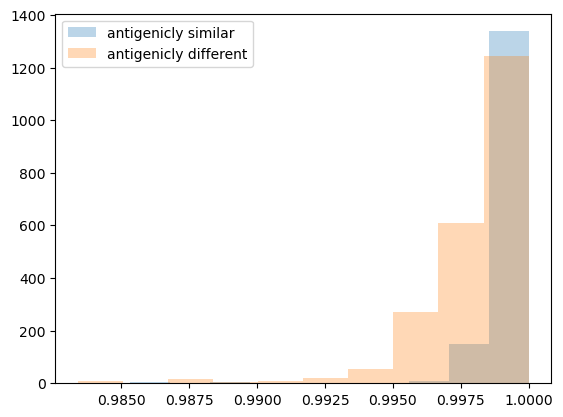

In [17]:
mean_distances_cos = np.array(mean_distances_cos)
plt.hist(mean_distances_cos[data_csv['Binary_crossreactivity'] == 1], alpha = 0.3, label = 'antigenicly similar')
plt.hist(mean_distances_cos[data_csv['Binary_crossreactivity'] == 0], alpha = 0.3, label = 'antigenicly different')
plt.legend()

In [20]:
print(CalculateAUC(true = data_csv['Binary_crossreactivity'], predicted = distances_emb_eucl))
print(CalculateAUC(true = data_csv['Binary_crossreactivity'], predicted = distances_emb_cos))
print(CalculateAUC(true = data_csv['Binary_crossreactivity'], predicted = mean_distances_eucl))
print(CalculateAUC(true = data_csv['Binary_crossreactivity'], predicted = mean_distances_cos))

(0.8395028991970133, [0.8270390240394758, 0.851761994425082])
(0.8392029414220663, [0.826727724317975, 0.8514718518439462])
(0.7891597392114398, [0.7747540490569749, 0.8032853100943199])
(0.7869885246163768, [0.7725018597072297, 0.8012141711053575])


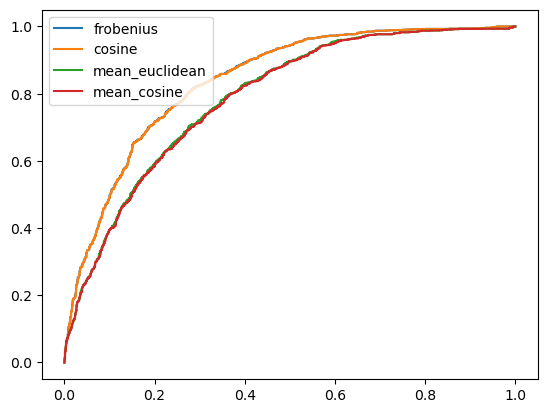

In [25]:
PlotAUC(true = data_csv['Binary_crossreactivity'], predicted = np.exp(-distances_emb_eucl), name = 'frobenius')
PlotAUC(true = data_csv['Binary_crossreactivity'], predicted = distances_emb_cos, name = 'cosine')
PlotAUC(true = data_csv['Binary_crossreactivity'], predicted = np.exp(-mean_distances_eucl), name = 'mean_euclidean')
PlotAUC(true = data_csv['Binary_crossreactivity'], predicted = mean_distances_cos, name = 'mean_cosine')

In [27]:
#load embeddings from larger model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
larger_embeddings = extract_representations(model, alphabet, number_of_chunks = 30, layer_to_extract = 33)

/home/elisenenkova/anaconda3/lib/python3.11/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [28]:
large_emb_dict = dict(zip(seq_dict.keys(), larger_embeddings))

In [30]:
#calculate the best performing norm on small embedding
large_distances_emb_eucl = []
for row in list(data_csv.index):
    Strain1_name = data_csv.loc[row, 'Strain1']
    Strain2_name = data_csv.loc[row, 'Strain2']
    emb1 = large_emb_dict[Strain1_name]
    emb2 = large_emb_dict[Strain2_name]
    large_distances_emb_eucl.append(norm(emb1 - emb2))

In [34]:
large_distances_emb_eucl = np.array(large_distances_emb_eucl)

In [31]:
print(CalculateAUC(true = data_csv['Binary_crossreactivity'], predicted = distances_emb_eucl))
print(CalculateAUC(true = data_csv['Binary_crossreactivity'], predicted = large_distances_emb_eucl))

(0.8395028991970133, [0.8270390240394758, 0.851761994425082])
(0.8189429108992159, [0.8059511411545662, 0.8318519475211622])


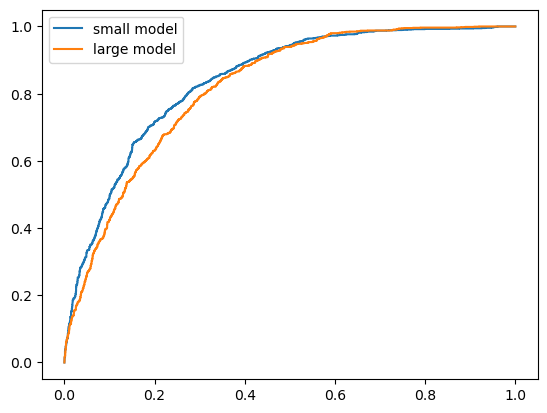

In [35]:
#compare ROC
PlotAUC(true = data_csv['Binary_crossreactivity'], predicted = np.exp(-distances_emb_eucl), name = 'small model')
PlotAUC(true = data_csv['Binary_crossreactivity'], predicted = np.exp(-large_distances_emb_eucl), name = 'large model')